<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Reproduction_of_a_foundational_PINN_method_to_generate_solution_to_1D_Burgers'_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations

https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [ ]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

# import torch

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
xMin = -1
xMax = 1
tMin = 0
tMax = 1

In [ ]:
# create dataset
Nu = 20 #20
Nf = 2000 #2000

Nu_i = int(0.8*Nu)
Nu_bc = Nu - Nu_i

In [ ]:
NuTrainingSet = np.zeros((Nu, 3))

In [ ]:
# initial conditions
uniformRandomXArray = rng.uniform(low=xMin, high=xMax, size=Nu_i)

Nu_iSet= np.array([
                    np.zeros(Nu_i),
                    uniformRandomXArray,
                    -1 * np.sin(np.pi * uniformRandomXArray)
                    ]).T

# boundary conditions
uniformRandomTArray = rng.uniform(low=tMin, high=tMax, size=Nu_bc)

Nu_bcSet = np.array([
                        uniformRandomTArray,
                        rng.choice(np.array([-1,1]), size=Nu_bc, replace=True),
                        np.zeros(Nu_bc)
                        ]).T

In [ ]:
NuTrainingSet[:Nu_i,:] = Nu_iSet.copy()

NuTrainingSet[Nu_i:,:] = Nu_bcSet.copy()



In [ ]:
rng.shuffle(NuTrainingSet)
NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
NuX = NuSetTensor[:,:2].requires_grad_()
Nuy = NuSetTensor[:,2]

In [ ]:
NfSet = np.array([
               rng.uniform(tMin, tMax, Nf),
               rng.uniform(xMin, xMax, Nf),
               ]).T

NfTensor = torch.from_numpy(NfSet.astype(np.float32)).requires_grad_()

In [ ]:
# create basic neural network u(x, t)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            # nn.Linear(2, 100),
            # nn.ReLU(),            
            # nn.Linear(100, 100),
            # nn.ReLU(),
            # nn.Linear(100, 100),
            # nn.ReLU(),
            # nn.Linear(100, 100),
            # nn.ReLU(),            
            # nn.Linear(100, 100),
            # nn.ReLU(),            
            # nn.Linear(100, 1),

            # nn.Linear(2, 32),
            # nn.Tanh(),
            # nn.Linear(32, 64),
            # nn.Tanh(),
            # nn.Linear(64, 32),
            # nn.Tanh(),
            # nn.Linear(32, 16),
            # nn.Tanh(),
            
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            # nn.Linear(20, 20),
            # nn.Tanh(),
            # nn.Linear(20, 20),
            # nn.Tanh(),
            nn.Linear(20, 20),         
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 1),
        )            

    def forward(self, inputs):
        # x = self.flatten(x)
        u = self.linear_relu_stack(inputs)
        return u

# nn.Linear(2, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),
# nn.Linear(20, 20),
# nn.ReLU(),            
# nn.Linear(20, 1),



In [ ]:
def residual(pointsArray_tx, v=(0.01/np.pi)):

    u = model(pointsArray_tx)#.requires_grad_()

    # print(u[-5:])

    firstDerivatives = torch.autograd.grad(u, pointsArray_tx, torch.ones_like(u), create_graph=True)[0]
    secondDerivatives = torch.autograd.grad(firstDerivatives, pointsArray_tx, torch.ones_like(firstDerivatives), retain_graph=True)[0]

    if len(list(pointsArray_tx.size())) > 1:  #len(list(NfTensor[1].size()))
        ut = firstDerivatives[:,0] 
        ux = firstDerivatives[:,1]
        uxx = secondDerivatives[:,1]
    
    else:
        ut = firstDerivatives[0] 
        ux = firstDerivatives[1]
        uxx = secondDerivatives[1]

    return ut.flatten() + u.flatten()*ux.flatten() - v*uxx.flatten()

In [ ]:
def meshPlot(xDim, yDim):

    #NfTensor = torch.from_numpy(NfSet.astype(np.float32)).requires_grad_()

    x = np.arange(tMin, tMax, (tMax-tMin)/xDim)
    y = np.arange(xMin, xMax, (xMax-xMin)/yDim)
    X,Y = np.meshgrid(x, y)

    flattenedCoords = np.zeros((xDim*yDim, 2))
    flattenedCoords[:,0] = X.flatten()
    flattenedCoords[:,1] = Y.flatten()

    flattenedCoords = torch.from_numpy(flattenedCoords.astype(np.float32))

    

    flattenedU = model(flattenedCoords)
    U = torch.reshape(flattenedU, (yDim, xDim)).detach().numpy()

    flattenedCoords = flattenedCoords.requires_grad_()

    # print(flattenedCoords[-5:])
    
    flattenedResidual_err = residual(flattenedCoords)

    # print('here')
    residual_err = torch.reshape(flattenedResidual_err, (yDim, xDim)).detach().numpy()
    
    # surf1 = ax.plot_surface(X, Y, U, cmap=mycmap)
    # fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5)

    return X, Y, U, residual_err

    

Parameters: 1761


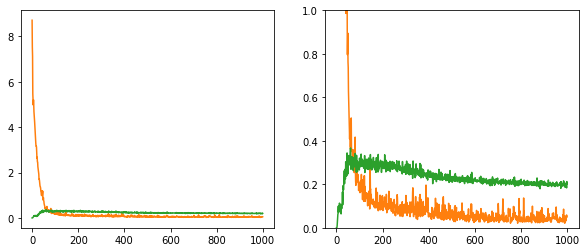

In [ ]:
model = NeuralNetwork()
print(f'Parameters: {sum(p.numel() for p in model.parameters())}')
# print(model)

MSEfunc = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())
# optimiser = torch.optim.LBFGS(model.parameters(), lr=1)

epochs = 1000

totalLoss = []
uLoss = []
fLoss = []

uBatchSize = 1
fBatchSize = 2000

model.train()
for epoch in range(epochs):


    fLossEpoch = 0
    
    
    for i in range(NfTensor.shape[0]//fBatchSize):
        optimiser.zero_grad()
        
        MSEf = MSEfunc(residual(NfTensor[i*fBatchSize:(i+1)*fBatchSize]), torch.zeros(fBatchSize)) #  #torch.zeros(fBatchSize) #torch.tensor([0.])

        fLossEpoch += MSEf.item()

        MSEf.backward()
        optimiser.step()
    
    
    fLoss.append(fLossEpoch)

    uLossEpoch = 0
    
    rng.shuffle(NuTrainingSet)
    NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
    NuX = NuSetTensor[:,:2].requires_grad_()
    Nuy = NuSetTensor[:,2]

    for i in range(NuX.shape[0]//uBatchSize):
        optimiser.zero_grad()

        MSEu = MSEfunc(model(NuX[i*uBatchSize:(i+1)*uBatchSize]), torch.reshape(Nuy[i*uBatchSize:(i+1)*uBatchSize], (uBatchSize,1)))

        uLossEpoch += MSEu.item()
        
        MSEu.backward()

        optimiser.step()
    
    uLoss.append(uLossEpoch)

    

    # loss = MSEu + MSEf 
    # totalLoss.append(loss.item()) 
    
    # optimiser.step(closure)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(totalLoss)
axs[0].plot(uLoss)
axs[0].plot(fLoss)

axs[1].plot(totalLoss)
axs[1].plot(uLoss)
axs[1].plot(fLoss)
axs[1].set_ylim([0, 1])

# with torch.no_grad():
model.eval()
X, Y, U, res = meshPlot(1000, 1000) 

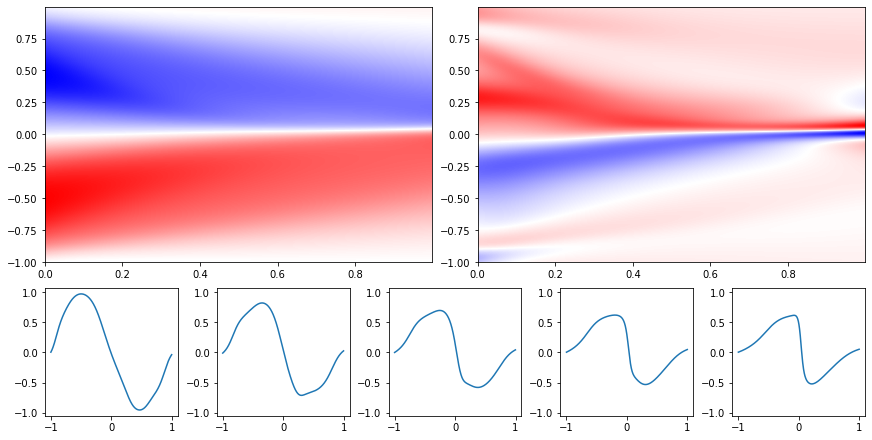

In [ ]:
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 10, figure=fig)

solutionPlot = fig.add_subplot(gs[:2,:5])
solutionPlot.pcolormesh(X,Y,U, cmap='bwr')
# fig.colorbar(ax=solutionPlot)

residualPlot = fig.add_subplot(gs[:2,5:], sharey=solutionPlot)
residualPlot.pcolormesh(X,Y,res, cmap='bwr')

t0Plot = fig.add_subplot(gs[2,:2])
t0Plot.plot(Y[:,0], U[:,0])

t025Plot = fig.add_subplot(gs[2,2:4], sharey=t0Plot)
t025Plot.plot(Y[:,Y.shape[1]//4], U[:,Y.shape[1]//4])

t05Plot = fig.add_subplot(gs[2,4:6], sharey=t0Plot)
t05Plot.plot(Y[:,2*Y.shape[1]//4], U[:,2*Y.shape[1]//4])

t075Plot = fig.add_subplot(gs[2,6:8], sharey=t0Plot)
t075Plot.plot(Y[:,3*Y.shape[1]//4], U[:,3*Y.shape[1]//4])

t1Plot = fig.add_subplot(gs[2,8:], sharey=t0Plot)
t1Plot.plot(Y[:,-1], U[:,-1])

# fig.colorbar(cf, ax=axs[0,1])

plt.show()